In [1]:
import pandas as pd
import math
import numpy as np
from futilities.distances import cal_dist
from futilities.distances import cal_depot
from futilities.transfloat import commatoperiod
from futilities.transfloat import strtofloat
from futilities.GA import GA
import matplotlib.pyplot as plt

In [2]:
muni_s = ['BARRANQUILLA']
current = ['2022-02-09']
cars = 4
op_limit = 20
vol_limit = [14.0,20.0]
CENDIS = [-74.8518516,10.9358485]
rng = np.random.default_rng(2022)

In [3]:
df = pd.read_csv('Lista_Datos_completos_data_09_02_Original.csv', sep=";")
lat = 'LATITUD'
lon = 'LONGITUD'
muni = 'MUN_DES'
date = 'FEC_DES'
volumen = 'M3'
neighborhood = 'NOMBRE_EQUIVALENTE'
identifier = "ID"
accvolumen = 'vol_cumulative'
accop = 'op_cumulative'
bucket_by_vol = 'vol_bucket'
bucket_by_op = 'op_bucket'
df[date] = pd.to_datetime(df[date],format='%d/%m/%Y')

In [4]:
is_muni = df.loc[:,muni].isin(muni_s)
is_date = df.loc[:,date].isin(current)
df_muni = df[(is_muni) & (is_date)].copy()
df_muni[volumen] = df_muni[volumen]/1000
df_muni = df_muni.sort_values(by=[neighborhood,volumen])
df_muni[accvolumen] = df_muni.groupby([neighborhood])[volumen].cumsum()
n_op = df_muni.shape[0]
M3_total = df_muni[volumen].sum()
min_car = math.ceil(max([n_op/vol_limit[0],M3_total/op_limit]))

In [5]:
volbucket_size = vol_limit[1]
df_muni[bucket_by_vol] = (df_muni[accvolumen]/volbucket_size).apply(math.ceil)
df_muni[accop] = df_muni.groupby([neighborhood,bucket_by_vol])[volumen].cumcount() + 1
opbucket_size = op_limit
df_muni[bucket_by_op] = (df_muni[accop]/opbucket_size).apply(math.ceil)
df_muni[identifier] = df_muni[neighborhood] + "_" + df_muni[bucket_by_vol].astype(str) + "_" + df_muni[bucket_by_op].astype(str)

In [6]:
try:
  df_muni.loc[:,(lat)] = strtofloat(commatoperiod(df_muni.loc[:,(lat)]))
  df_muni.loc[:,(lon)] = strtofloat(commatoperiod(df_muni.loc[:,(lon)]))
  dist_matrix = cal_dist(df_muni,lat,lon,identifier)
  dist_CENDIS = cal_depot(df_muni, lat, lon, identifier, CENDIS)
except:
  print("Revise las latitudes y longitudes en su archivo, pueden haber algunas erróneas")

In [7]:
info_s = 'sum'
info_c = 'count'
info_table = df_muni.groupby(identifier)[volumen].agg([info_s,info_c])
info_table

,sum,count
ID,,
BAQ - ABAJO_1_1,0.375,2
BAQ - ADELITA DE CHAR_1_1,0.719,1
BAQ - ALAMEDA DEL RIO_1_1,0.350,2
BAQ - ALTOS DEL PRADO_1_1,0.100,1
BAQ - BELLAVISTA_1_1,2.444,1
BAQ - BELLO HORIZONTE_1_1,2.087,1
BAQ - BUENA VISTA_1_1,0.390,1
BAQ - CHIQUINQUIRA_1_1,0.150,1
BAQ - CIUDAD CARIBE_1_1,1.212,2


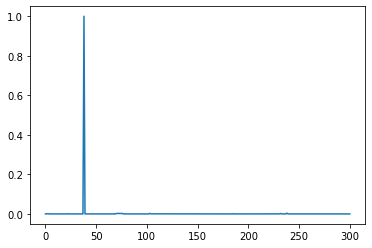

In [8]:
epocas = 300
Model = GA(df_muni,dist_matrix,dist_CENDIS,info_table,cars,vol_limit,op_limit,rng=rng)
Model.evolution(epocas)
plt.plot(Model.means/Model.means.max())

In [9]:
carOrg = np.empty([Model.noptions],dtype=int)

RouteModel = Model.orderingTraceSample(Model.bestOfBest["Cars"],Model.bestOfBest["Tour"])
CarsModel = Model.bestOfBest["Cars"]

for car in range(len(CarsModel)):
    carOrg[CarsModel[car]['inicio']:CarsModel[car]['fin']+1] = car + 1

df_muni["CAMION"] = df_muni['ID'].apply(lambda x: carOrg[np.where(RouteModel == x)][0])
df_muni["ORDEN"] = df_muni['ID'].apply(lambda x: np.where(RouteModel == x)[0][0])
df_muni = df_muni.sort_values(by=['CAMION',"ORDEN"])

In [10]:
df_final_muni = df_muni.drop(['vol_cumulative','vol_bucket',"op_cumulative","op_bucket","ID","ORDEN"], axis = 1) 
df_final_muni.to_excel("output.xlsx")

Text(-74.85160160000001, 10.9360985, 'CENDIS')

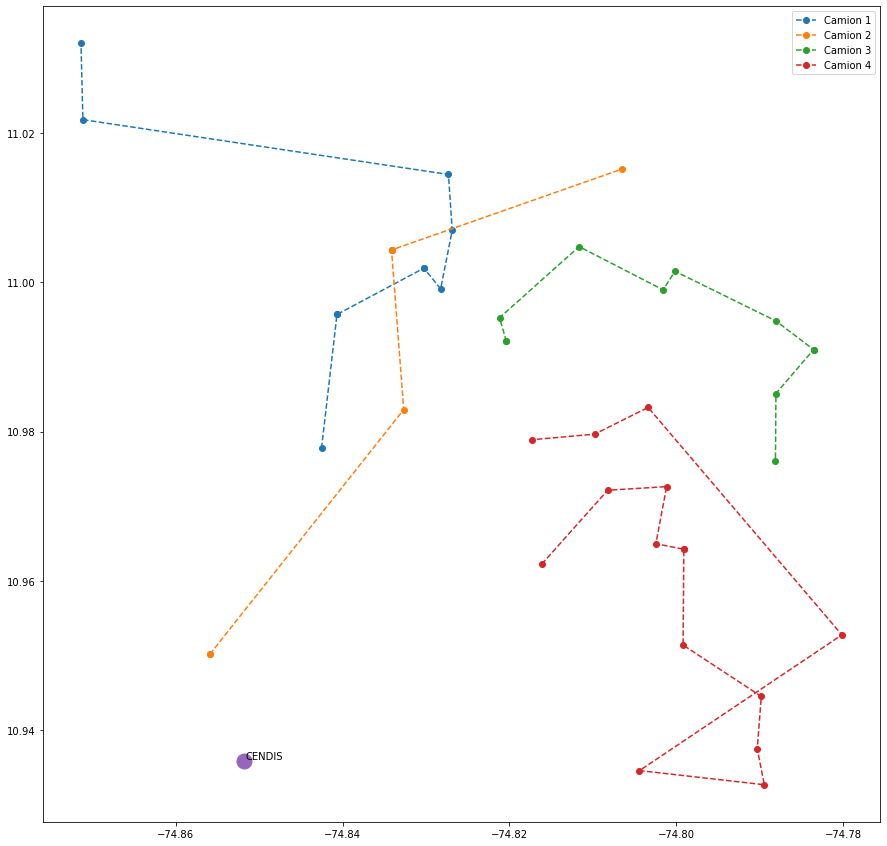

In [11]:
fig, ax = plt.subplots(figsize=(15,15))

for car in range(cars):
    pointsInCar = df_final_muni[df_final_muni['CAMION']==car+1]
    ax.plot(pointsInCar[lon].values, pointsInCar[lat].values,"--o",label='Camion '+str(car+1))
ax.legend()
ax.plot(CENDIS[0], CENDIS[1],"--o",markersize=15)
ax.annotate("CENDIS", xy=(CENDIS[0]+0.00025, CENDIS[1]+0.00025))

Text(-74.85160160000001, 10.9360985, 'CENDIS')

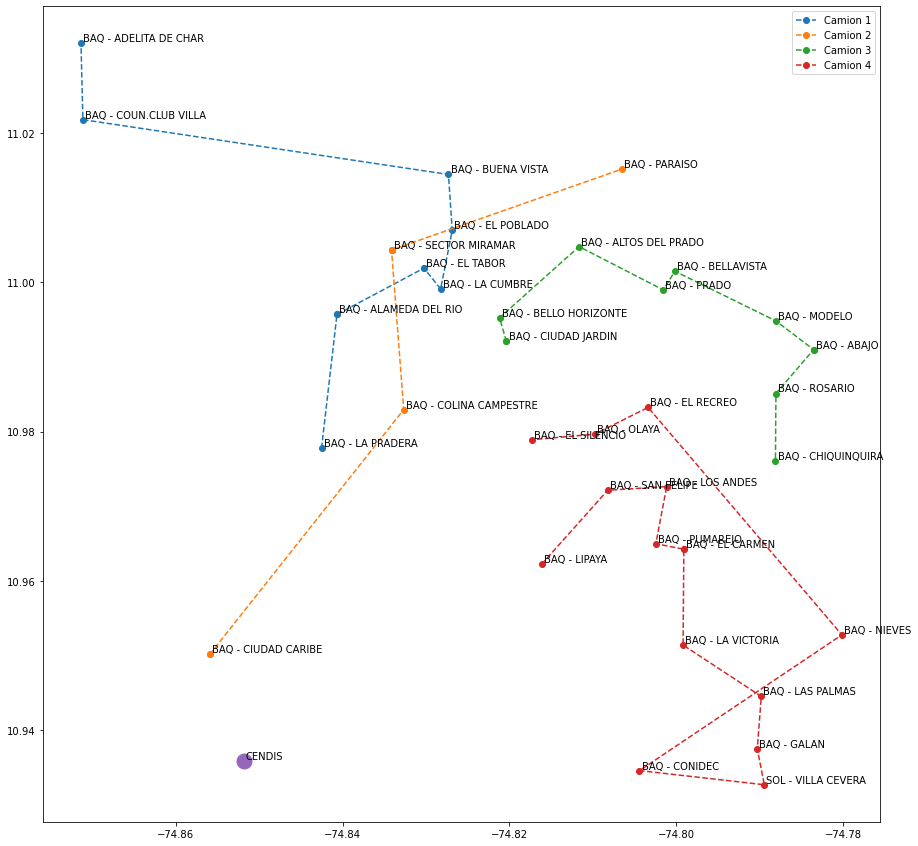

In [12]:
fig, ax = plt.subplots(figsize=(15,15))

for car in range(cars):
    pointsInCar = df_final_muni[df_final_muni['CAMION']==car+1]
    ax.plot(pointsInCar[lon].values, pointsInCar[lat].values,"--o",label='Camion '+str(car+1))
ax.legend()
ax.plot(CENDIS[0], CENDIS[1],"--o",markersize=15)

neighbors = df_final_muni.drop_duplicates(subset=[neighborhood])

for i, point in neighbors.iterrows():
    ax.annotate(point[neighborhood], xy=(point[lon]+0.00025, point[lat]+0.00025))
ax.annotate("CENDIS", xy=(CENDIS[0]+0.00025, CENDIS[1]+0.00025))